In [ ]:
import warnings
from itertools import cycle
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as fnn
from botorch.test_functions.multi_objective import (
    DTLZ2,
    ZDT3,
    BraninCurrin,
    GMM
)
from botorch.utils.multi_objective.hypervolume import Hypervolume
from scipy.stats.qmc import LatinHypercube

from vsd.acquisition import (
    LogPIClassiferAcquisition,
    VariationalPreferenceAcquisition,
    VariationalSearchAcquisition
)
from vsd.proposals import GaussianKDEProposal
from vsd.condproposals import (
    ConditionalGaussianProposal,
    PreferenceSearchDistribution
)
from vsd.cpe import (
    ContinuousCPEModel,
    PreferenceContinuousCPE,
    fit_cpe_labels,
    make_constrastive_alignment_data
)
from vsd.generation import generate_candidates_iw
from vsd.preferences import EmpiricalPreferences, MixtureUnitNormal, UnitNormal
from vsd.proposals import fit_ml
from vsd.utils import is_non_dominated_strict

warnings.filterwarnings("ignore")

/Users/ste702/Code/agps/.env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Config
N_INIT = 64
BATCH_SIZE = 5
GP_BOUNDS = 15
N_ITER = 10
USE_EMPIRICAL_PREFERENCES = False
SAMPLES = 128
FUNCTION = "ZDT3"
# FUNCTION = "BraninCurrin"
# FUNCTION = "DTLZ2"
# FUNCTION = "GMM"

obj_mappings = {
    "DTLZ2": dict(f=DTLZ2, args=dict(dim=3, num_objectives=2, negate=True), yscale=[1., 1.], ref=None, sigmoid=True, start_scale=2),
    "BraninCurrin": dict(f=BraninCurrin, args=dict(negate=False), yscale=[200., 4.], ref=[0.3, 0.3], sigmoid=True, start_scale=2.5),
    # "ZDT3": dict(f=ZDT3, args=dict(dim=6, num_objectives=2, negate=False), yscale=[1., 1.], ref=[-.1, -.1], sigmoid=True, start_scale=2.),
    "ZDT3": dict(f=ZDT3, args=dict(dim=6, num_objectives=2, negate=True), yscale=[1., 1.], ref=[-1, -3], sigmoid=True, start_scale=2.),
    "GMM": dict(f=GMM, args=dict(num_objectives=2, negate=True), yscale=[1., 1.], ref=[0., 0.], sigmoid=True, start_scale=4)
}

plt.rcParams.update(
    {
        "font.size": 12,
        "axes.labelsize": 14,
        "axes.titlesize": 16,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
    }
)

In [3]:
class BBWrapper(obj_mappings[FUNCTION]["f"]):
    def __init__(self):
        super().__init__(**obj_mappings[FUNCTION]["args"])
        self.yscale = torch.tensor(obj_mappings[FUNCTION]["yscale"]).float()
        if obj_mappings[FUNCTION]["ref"] is None:
            self.ref_point = self.ref_point / self.yscale
        else:
            self.ref_point = torch.tensor(obj_mappings[FUNCTION]["ref"]).float()

    def __call__(self, X):
        if obj_mappings[FUNCTION]["sigmoid"]:
            X = torch.sigmoid(X)
        return super().__call__(X).float() / self.yscale

bb = BBWrapper()
M = 2
D = bb.dim if hasattr(bb, "dim") else 2
ref_point = bb.ref_point.float()

In [4]:
s = obj_mappings[FUNCTION]["start_scale"] * 2
b = obj_mappings[FUNCTION]["start_scale"]
X_init = torch.tensor(LatinHypercube(d=D).random(n=N_INIT) * s - b).float()
y_init = bb(X_init)

In [ ]:
def vsd_callback(i, loss, grads):
    if (i % 100) == 0:
        gmean = sum([g.detach().mean() for g in grads if g is not None]) / len(grads)
        print(f"  {i}: loss = {loss:.3f}, mean grad = {gmean:.3f}")

def callback(i, loss, _):
    if (i % 100) == 0:
        print(f"  {i}: loss = {loss:.3f}")

class AGPS():

    def __init__(self, K: int):
        if K == 0:
            self.preferences = EmpiricalPreferences()
        if K == 1:
            self.preferences = UnitNormal(dim=2)
        else:
            mu = torch.rand((K, 2))
            self.preferences = MixtureUnitNormal(locs=mu)
        self.pareto_cpe = PreferenceContinuousCPE(x_dim=D, u_dims=M, latent_dim=16, dropoutp=0.1, hidden_layers=2)
        self.preference_cpe = PreferenceContinuousCPE(x_dim=D, u_dims=M, latent_dim=16, dropoutp=0.1, hidden_layers=2)
        prior = torch.distributions.MultivariateNormal(loc=torch.zeros((1, D)), precision_matrix=torch.eye(D) * 0.01)
        # cproposal = ConditionalGaussianProposal(x_dims=D, u_dims=M, latent_dim=32, hidden_layers=2, bias=True)
        cproposal = ConditionalGaussianProposal(x_dims=D, u_dims=M, latent_dim=64, hidden_layers=4, bias=True)
        self.proposal = PreferenceSearchDistribution(cproposal=cproposal, preference=self.preferences)
        self.acq = VariationalPreferenceAcquisition(pareto_model=self.pareto_cpe, pref_model=self.preference_cpe, prior_dist=prior)

    def fit(self, X, y, round):
        print(f"Running A-GPS round {round} ...")
        z = is_non_dominated_strict(y).float()
        U = fnn.normalize(y - ref_point, p=2, dim=1)
        # Augment dataset with misalignments
        Xa, Ua, za = make_constrastive_alignment_data(X, U)
        if USE_EMPIRICAL_PREFERENCES:
            self.preferences.set_preferences(U[z==1, :] if round > 0 else U)
        else:
            print("Fitting preferences.")
            fit_ml(
                self.preferences,
                U[z==1, :] if round > 0 else U,
                optimizer_options=dict(lr=1e-3, weight_decay=1e-6),
                stop_options=dict(n_window=500, maxiter=10000),
                callback=callback
            )
        cpe_opt_options = dict(lr=1e-3, weight_decay=1e-6)
        cpe_stop_options = dict(n_window=1000, maxiter=10000)
        print("Fitting Pareto CPE.")
        fit_cpe_labels(
            self.pareto_cpe,
            X,
            z,
            U,
            optimizer_options=cpe_opt_options,
            stop_options=cpe_stop_options,
            callback=callback,
            batch_size=32
        )
        print("Fitting Alignment CPE.")
        fit_cpe_labels(
            self.preference_cpe,
            Xa,
            za,
            Ua,
            optimizer_options=cpe_opt_options,
            stop_options=cpe_stop_options,
            callback=callback,
            batch_size=32
        )
        print("Fitting AGPS.")
        generate_candidates_iw(
            self.acq,
            self.proposal,
            optimizer_options=dict(lr=1e-3),
            stop_options=dict(n_window=4000, maxiter=10000),
            gradient_samples=SAMPLES,
            callback=vsd_callback
        )
        return self.proposal.sample(torch.Size([BATCH_SIZE]))


class VSD():

    def __init__(self):
        self.pareto_cpe = ContinuousCPEModel(x_dim=D, latent_dim=16, dropoutp=0.1, hidden_layers=2)
        prior = torch.distributions.MultivariateNormal(loc=torch.zeros((1, D)), precision_matrix=torch.eye(D) * 0.01)
        self.proposal = GaussianKDEProposal(d_features=D, k_components=5)
        self.acq = VariationalSearchAcquisition(acquisition=LogPIClassiferAcquisition(self.pareto_cpe), prior_dist=prior)

    def fit(self, X, y, round):
        print(f"Running VSD round {round}...")
        z = is_non_dominated_strict(y)
        cpe_opt_options = dict(lr=1e-3, weight_decay=1e-6)
        cpe_stop_options = dict(n_window=1000, maxiter=10000)
        print("Fitting Pareto CPE.")
        fit_cpe_labels(
            self.pareto_cpe,
            X,
            z.float(),
            optimizer_options=cpe_opt_options,
            stop_options=cpe_stop_options,
            callback=callback,
            batch_size=32
        )
        print("Fitting VSD.")
        generate_candidates_iw(
            self.acq,
            self.proposal,
            optimizer_options=dict(lr=1e-3),
            stop_options=dict(n_window=4000, maxiter=10000),
            gradient_samples=SAMPLES,
            callback=vsd_callback
        )
        return self.proposal.sample(torch.Size([BATCH_SIZE])), None

In [ ]:
N_RUNS = 5
N_ITER = 10

results = {m: [] for m in ["A-GPS K = 1", "A-GPS K = 5", "A-GPS empirical"]}
models = {}

for m in results.keys():
    # Run methods multiple times
    for run in range(N_RUNS):
        X_vsd, y_vsd = X_init.clone(), y_init.clone()
        hv_vsd = []
        hv_comp = Hypervolume(ref_point=ref_point)
        if m == "VSD":
            method = VSD()
        elif "A-GPS K = 1":
            method = AGPS(K=1)
        elif "A-GPS K = 5":
            method = AGPS(K=5)
        else:
            method = AGPS(K=0)
        hv_vsd.append(hv_comp.compute(y_vsd[is_non_dominated_strict(y_vsd)]))
        for t in range(N_ITER):
            Xc, _ = method.fit(X_vsd, y_vsd, t)
            yc = bb(Xc)
            X_vsd = torch.cat([X_vsd, Xc], dim=0)
            y_vsd = torch.cat([y_vsd, yc], dim=0)
            hv_vsd.append(hv_comp.compute(y_vsd[is_non_dominated_strict(y_vsd)]))
        results[m].append(hv_vsd)
    models[m] = method  # Save the last run of each method for plotting samples

Running A-GPS round 0 ...
Fitting preferences.
  0: loss = 2.293
  100: loss = 2.088
  200: loss = 1.874
  300: loss = 1.646
  400: loss = 1.410
  500: loss = 1.173
  600: loss = 0.944
  700: loss = 0.729
  800: loss = 0.528
  900: loss = 0.337
  1000: loss = 0.151
  1100: loss = -0.033
  1200: loss = -0.216
  1300: loss = -0.396
  1400: loss = -0.574
  1500: loss = -0.749
  1600: loss = -0.920
  1700: loss = -1.086
  1800: loss = -1.247
  1900: loss = -1.400
  2000: loss = -1.546
  2100: loss = -1.685
  2200: loss = -1.815
  2300: loss = -1.937
  2400: loss = -2.051
  2500: loss = -2.158
  2600: loss = -2.258
  2700: loss = -2.353
  2800: loss = -2.442
  2900: loss = -2.527
  3000: loss = -2.607
  3100: loss = -2.683
  3200: loss = -2.753
  3300: loss = -2.818
  3400: loss = -2.876
  3500: loss = -2.929
  3600: loss = -2.974
  3700: loss = -3.013
  3800: loss = -3.045
  3900: loss = -3.070
  4000: loss = -3.090
  4100: loss = -3.105
  4200: loss = -3.115
  4300: loss = -3.122
  4400: 

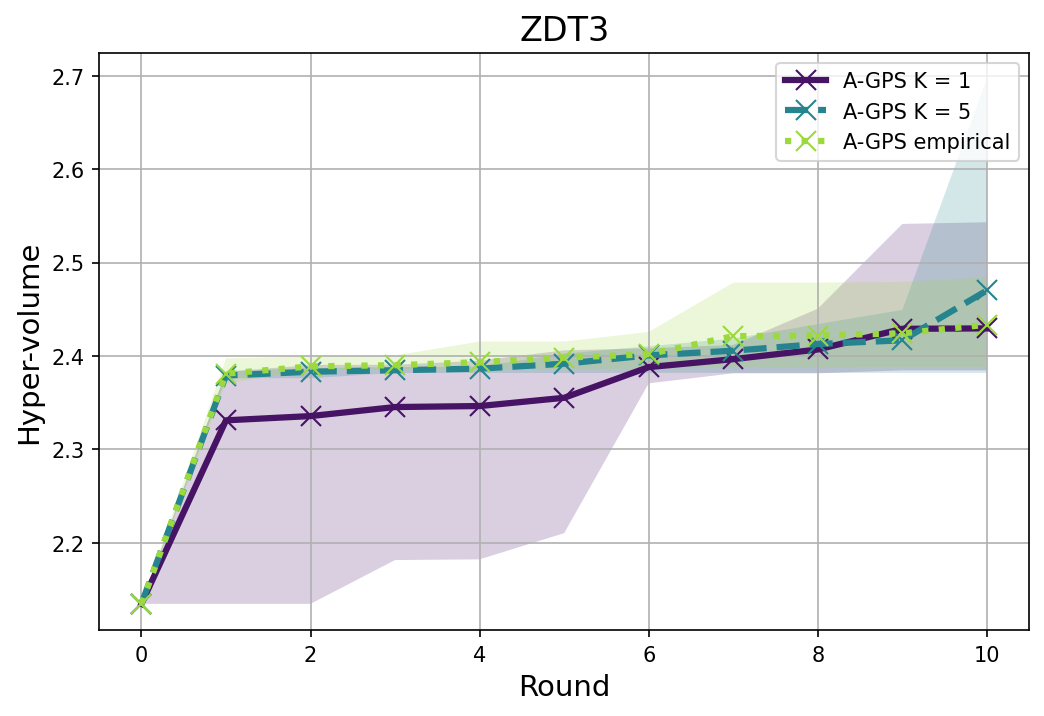

In [7]:
LINECYCLE = cycle(
    [
        "-",
        "--",
        ":",
        "-.",
        (0, (3, 1, 1, 1)),
        (0, (5, 1)),
        (0, (3, 1, 1, 1, 1, 1)),
        (0, (1, 1)),
    ]
)
cycler = plt.cycler(
        color=plt.cm.viridis(np.linspace(0.05, 0.85, 3))
    ) + plt.cycler(linestyle=[next(LINECYCLE) for _ in range(3)])
plt.rc("axes", prop_cycle=cycler)

plt.figure(dpi=150, figsize=(8, 5))

for method, hvs in results.items():
    hvs_array = np.array(hvs)
    mean = hvs_array.mean(axis=0)
    lower = hvs_array.min(axis=0)
    upper = hvs_array.max(axis=0)

    plt.plot(
        mean,
        label=method,
        marker='o' if method == 'A-GPS' else 'x',
        markersize=10,
        linewidth=3,
    )
    plt.fill_between(range(N_ITER+1), lower, upper, alpha=0.2)

plt.xlabel("Round")
plt.ylabel("Hyper-volume")
plt.title(FUNCTION)
plt.legend()
plt.grid()
plt.show()

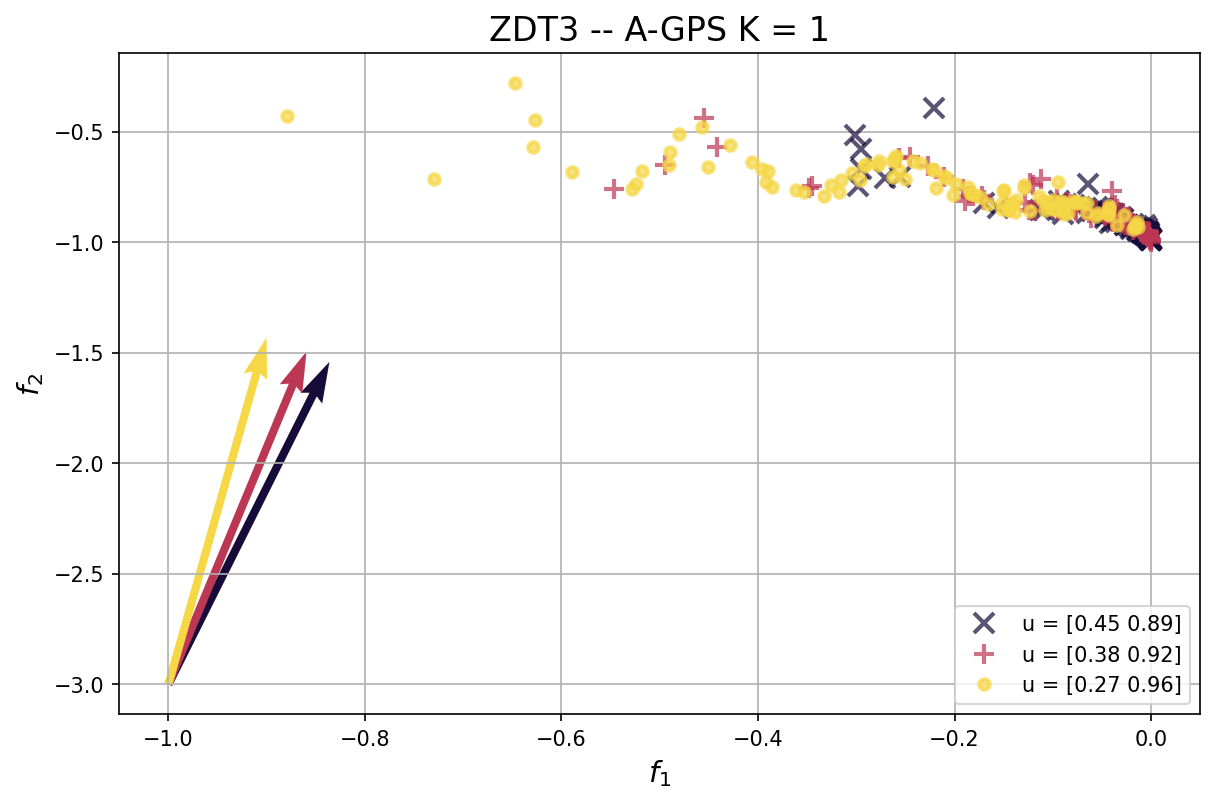

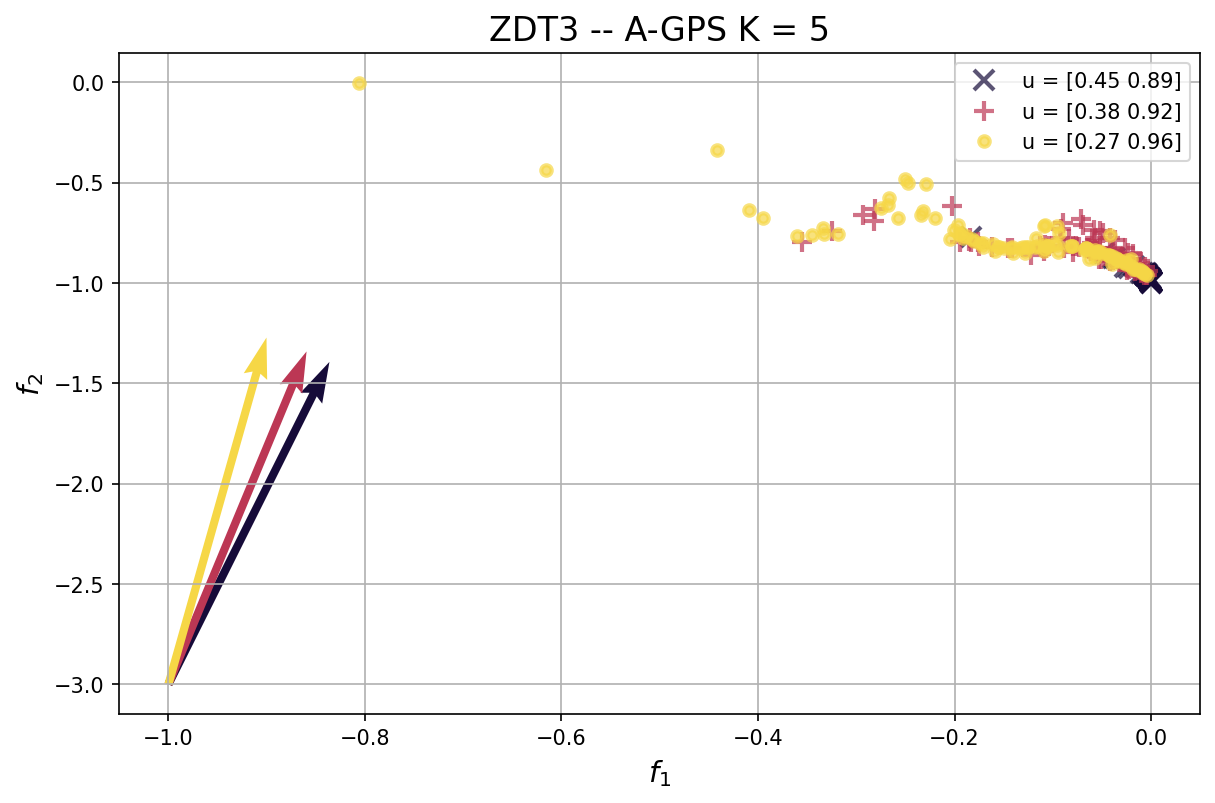

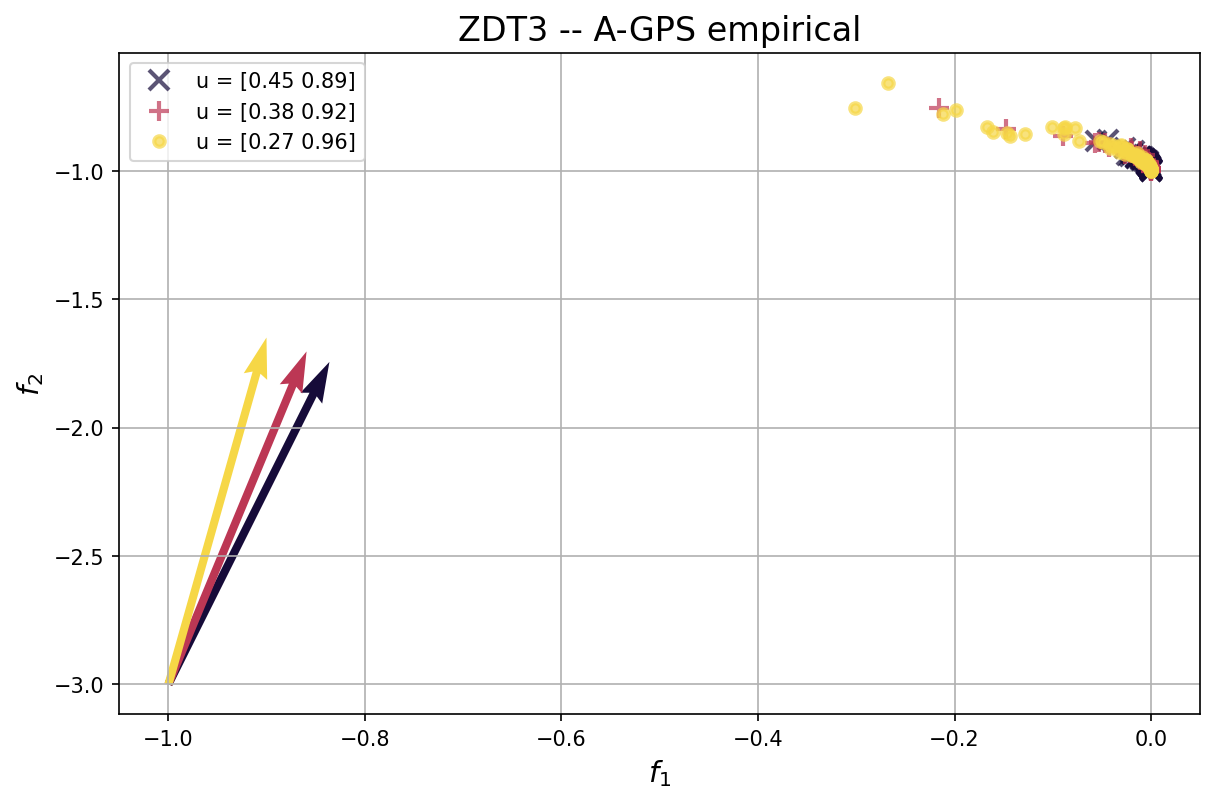

In [ ]:
# Demonstrate conditioning
np.set_printoptions(suppress=True, precision=2) # Set the precision of the output to 3
condsamples = 100
yplt = y_vsd[is_non_dominated_strict(y_vsd)]
uf1 = torch.tensor([torch.quantile(yplt[:, 0], q=0.9), torch.quantile(yplt[:, 1], q=0.1)]) - ref_point
uf2 = torch.tensor([yplt[:, 0].mean(), yplt[:, 1].mean()]) - ref_point
uf3 = torch.tensor([torch.quantile(yplt[:, 0], q=0.1), torch.quantile(yplt[:, 1], q=0.9)]) - ref_point
cols = plt.cm.inferno([0.1, 0.5, 0.9])

for name, model in models.items():
    if name == "VSD":
        continue
    plt.figure(dpi=150, figsize=(8, 5))
    for uf, marker, col in zip([uf1, uf2, uf3], ["x", '+', '.'], cols):
        uf = fnn.normalize(uf, p=2, dim=-1)
        ufs = torch.tile(uf, (condsamples, 1))
        xcand, _ = model.proposal.cproposal(ufs)
        ycand = bb(xcand)
        plt.plot(*ycand.T, marker, label=f"u = {uf.numpy()}", c=col, markersize=10,
                 alpha=0.7, mew=2)
        plt.quiver(ref_point[0], ref_point[1], uf[0], uf[1], color=col, scale=3)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.title(f"{FUNCTION} -- {name}")
    plt.xlabel("$f_1$")
    plt.ylabel("$f_2$")
    plt.show()